In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
BVH_CHANNELS = {
    "POSITION": ["Xposition", "Yposition", "Zposition"],
    "ROTATION": ["Zrotation", "Xrotation", "Yrotation"],
    "ALL": [
        "Xposition",
        "Yposition",
        "Zposition",
        "Zrotation",
        "Xrotation",
        "Yrotation",
    ],
}


def to_feature_values(
    df: pd.DataFrame,
    window_size_frame=3 * 60,  # ウィンドウサイズ
    gap_size_frame=1 * 1,  # ウィンドウの間隔
) -> pd.DataFrame:
    """
    スケルトンのDaraFrameを特徴量のDataFrameに変換する

    Parameters
    ----------
    df : pd.DataFrame
        スケルトンのDataFrame
    window_size : int, optional
        ウィンドウサイズ, by default 100
    gap : int, optional
        ウィンドウの間隔, by default 10
    """

    feature_values_df = pd.DataFrame()

    end = len(df) - window_size_frame
    for i in range(0, end, gap_size_frame):
        part_df = df.iloc[i : i + window_size_frame]

        # 上半身のスケルトンの平均
        upper_joint_keys = [
            "torso_1",
            "torso_2",
            "torso_3",
            "torso_4",
            "torso_5",
            "torso_6",
            "torso_7",
            "l_shoulder",
            "l_up_arm",
            "l_low_arm",
            "l_hand",
            "r_shoulder",
            "r_up_arm",
            "r_low_arm",
            "r_hand",
        ]
        upper_joint_columns = [
            f"{j}_{k}" for j in upper_joint_keys for k in BVH_CHANNELS["ALL"]
        ]
        upper_part_df = part_df[upper_joint_columns]
        upper_part_df_avg = upper_part_df.mean()
        upper_part_df_var = upper_part_df.var()

        # 位置の平均
        position_columns = [f"root_{c}" for c in BVH_CHANNELS["ALL"]]
        position_part_df = part_df[position_columns]
        position_part_df_avg = position_part_df.mean()
        position_part_df_var = position_part_df.var()

        # feature_values_df に追加
        line = (
            pd.concat(
                [
                    upper_part_df_avg,  # 上半身の平均
                    upper_part_df_var,  # 上半身の分散
                    position_part_df_avg,  # 位置の平均
                    position_part_df_var,  # 位置の分散
                ],
            )
            .to_frame()
            .T
        )
        line.columns = list(map(lambda x: f"{x[1]}-{x[0]}", enumerate(line.columns)))
        feature_values_df = pd.concat([feature_values_df, line])

    return feature_values_df

In [3]:
answer = pd.read_csv("../data/input/4/label.csv")
test_df = pd.read_csv("../data/input/4/motion.csv")
X_test = to_feature_values(test_df)

In [4]:
# モデルを読み込み
clf_random_forest = pickle.load(open("model/random_forest.pkl", "rb"))
clf_xgboost = pickle.load(open("model/xgboost.pkl", "rb"))
clf_lightgbm = pickle.load(open("model/lightgbm.pkl", "rb"))

# ラベルを読み込み
labels = pd.read_csv("model/labels.csv", header=None).values.flatten()

In [5]:
# テスト
y_pred_random_forest = clf_random_forest.predict(X_test)
y_pred_xgboost = clf_xgboost.predict(X_test)
y_pred_lightgbm = clf_lightgbm.predict(X_test)

In [ ]:
FRAM_RATE = 60


def color_map(index=None, label=None):
    colors = [
        "red",
        "blue",
        "yellow",
        "purple",
        "green",
        "orange",
        "pink",
        "brown",
        "gray",
        "cyan",
        "magenta",
        "lime",
        "olive",
        "navy",
    ]

    if index is not None:
        return colors[index % len(colors)]
    if label is not None:
        # labels の index を取得
        try:
            i = list(labels).index(label)
            return colors[i % len(colors)]
        except ValueError:
            return "white"


def plot_pred(pred, ans: pd.DataFrame, title: str):
    plt.figure(figsize=(16, 2))
    plt.title(title)
    plt.xlim(0, (len(pred) + 1) / FRAM_RATE)
    plt.xlabel("time [s]")

    # 背景色を color_map に従って描画
    for i, p in enumerate(pred):
        plt.axvspan(
            i / FRAM_RATE,
            (i + 1) / FRAM_RATE,
            color=color_map(index=p),
            # alpha=0.5,
            ymin=0.5,
            ymax=1,
        )

    # 正解ラベルをグラフに描画
    for i, a in ans.iterrows():
        plt.axvspan(
            i / FRAM_RATE,
            (i + 1) / FRAM_RATE,
            color=color_map(index=int(a.iloc[0])),
            alpha=0.5,
            ymin=0,
            ymax=0.5,
        )

1_移動してねぎを洗う: red
2_ねぎを切る: blue
3_卵を割る : yellow
4_卵をまぜる: purple
5_油をしく : green
6_卵流し込む: orange
7_炒める  : pink
8_米とねぎ入れる: brown
9_味付けする: gray
10_その他 : cyan
11_その他 : magenta


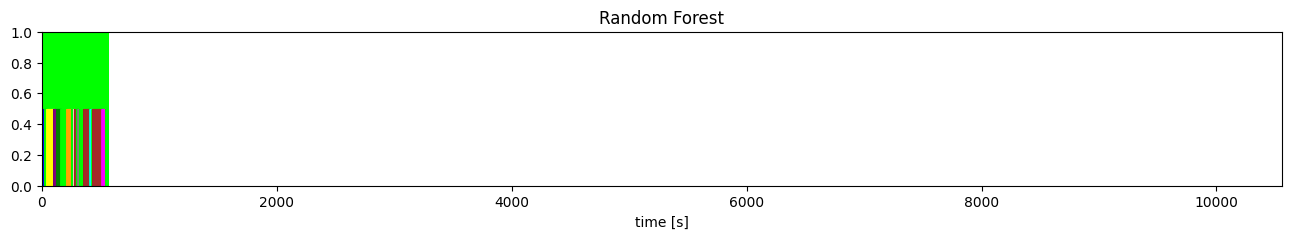

In [15]:
# グラフの描画
for label in labels:
    color = color_map(label=label)
    print(f"{label:7}: {color}")

plot_pred(y_pred_random_forest, answer, "Random Forest")
# plot_pred(y_pred_xgboost, answer, "XGBoost")
# plot_pred(y_pred_lightgbm, answer, "LightGBM")